# TD4: Résaux de neurones : modèles de taux de décharge

Dans ce TD, nous allons étudier la dynamique de réseaux de neurones où différentes *populations de neurones* sont représentés par leur taux de décharge moyen. Ces populations peuvent être couplées par des connexions synaptiques, ce qui rend la dynamique de ces modèles potentiellement très riche.

Par ailleurs, ces modèles sont aussi très étudiés comme une approximation de réseaux récurrents de neurones, où le couplage entre toutes les unités, avec certaines contraintes, peut produire n'importe quel dynamique souhaité suite à un apprentissage des poids des connexions.

Ici, nous allons d'abord étudier des réseaux à basse dimension, c'est-à-dire avec une ou deux populations de neurones, pour développer une compréhension des modèles à taux de décharge. Si le temps le permet, nous pourrons implémenter une version du "bump attractor model" que nous avons rapidement vu dans le cours.

## 1| Une seule population avec connexions récurrentes

Pour une seule population de neurones, la dynamique du taux de décharge $r(t)$ est donné par l'équation différentielle

$$\frac{dr}{dt} = \frac{\Phi(I_{ext}+wr(t)) - r(t)}{\tau},$$ 

où $\Phi(I)$ est la *fonction de transfert*, ou courbe $f-I$, qui donne le taux de décharge stationnaire du réseau pour un courant constant $I$. Dans le modèle, le courant synaptique que la population reçoit est donné par la somme d'une courant provénant d'autres régions du cervau ou d'autres populations de neurones, $I_{ext}$, et le courant synaptique lié aux connexions récurrentes, proportionnel au taux de décharge de la population même, $I_{rec}=w r(t)$, avec un poids de connexion effective $w$. Pour des neurones excitateurs, $w>0$, pour des neurones inhibiteurs, $w<0$. Enfin, $\tau$ est le temps caractéristique de la relaxation du taux de décharge vers la valeur stationnaire. 



### La fonction de transfert

On peut choisir différentes fonctions pour $\Phi(I)$, seulement il faut que la fonction soit toujours positive, $\Phi(I)\ge 0$, et monotone, $\Phi(I_1)\ge \Phi(I_2)$ si $I_1>I_2$.

Ici, on va utiliser une sigmoïde, 
$$\Phi(I) = r_{max} \frac{\tanh[\kappa(I-I_{half})] + 1}{2},$$
avec les paramètres suivants : $r_{max}$ - le taux de décharge maximale, $\kappa$ - la 'raideur' de la courbe $f-I$, et $I_{half}$ - le courant pour lequel le taux de décharge sera $r_{max}/2$.

Ce choix est assez "générique" dans le sens où la fonction ressemble à des courbes $f-I$ observées, tout en étant très aisément parametrisable, et implémenter numériquement. L'inverse et la dérivé sont également connues, ce qui s'averera utile pour des calculs. 

**Remarque :** Une fois implémenté, nous n'avons plus à nous soucier de la fonction de transfert dans nos simulations ou calculs, qu'elle soit compliquée ou non !


In [48]:
# uncomment for interactive plots
%matplotlib notebook

# comment above and uncomment below for 
# 'passive' plots (image only)
#%matplotlib inline

# import necessary modules for numerics and plotting
import numpy as np
import matplotlib.pyplot as plt

In [49]:
# Definition of the f-I curve 

# NOTE: I added keyword arguments with default values to the 
# function definitions after the TD 

# set standard parameters 
# --> these will be used as default parameters
# in the function definitions
rmax = 500.0     # (could be Hz)
Ihalf = 10.0   # (could be pA)
kappa = 0.2  # (1/unit of current)

# f-I curve
def fI(I, kappa=kappa, Ihalf=Ihalf, rmax=rmax):
    """fI(I, kwargs**) returns the population firing rate (in Hz) 
    for a given input current I (in mV)."""
    return rmax*0.5*(1.0+np.tanh((I-Ihalf)*kappa))

# we need the inverse function as well:
def fI_inv(r, kappa=kappa, Ihalf=Ihalf, rmax=rmax):
    y = 2.0*r/rmax - 1.0
    return np.arctanh(y)/kappa + Ihalf

# and also its derivative with respect to current
def fI_deriv(I, kappa=kappa, Ihalf=Ihalf, rmax=rmax):
    y = (I-Ihalf)*kappa
    return rmax*0.5*(1.0-np.tanh(y)**2)*kappa

<IPython.core.display.Javascript object>


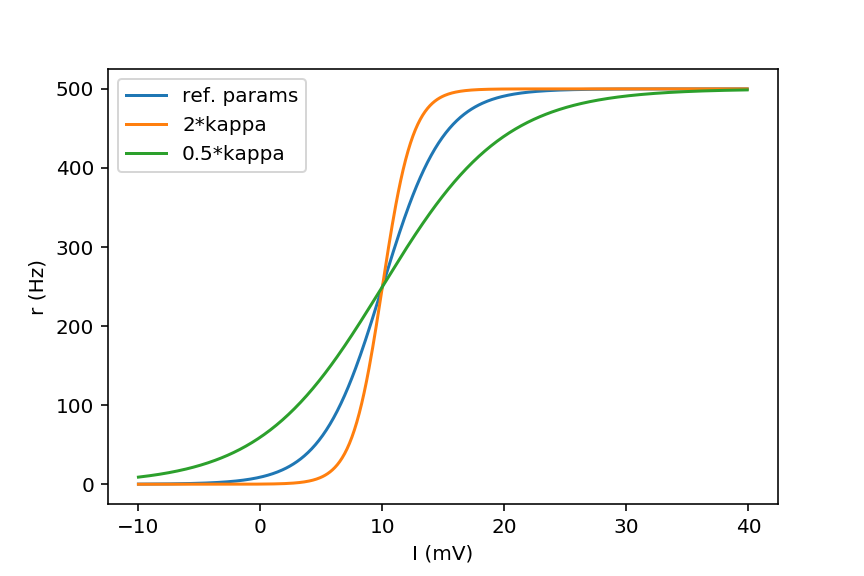

In [50]:
# Plottez la courbe f-I, c.à.d., le taux de décharge
# vs. le courant entrant total
# (Vous pouvez jouer avec les paramètres pour voir 
# comment la courbe se modifie.)

I = np.arange(-10,40,0.1)

fig, ax = plt.subplots()
ax.plot(I, fI(I), label='ref. params')
ax.plot(I, fI(I, kappa=2*kappa), label='2*kappa')
ax.plot(I, fI(I, kappa=0.5*kappa), label='0.5*kappa')
ax.set_xlabel('I (mV)')
ax.set_ylabel('r (Hz)')
ax.legend()

<IPython.core.display.Javascript object>


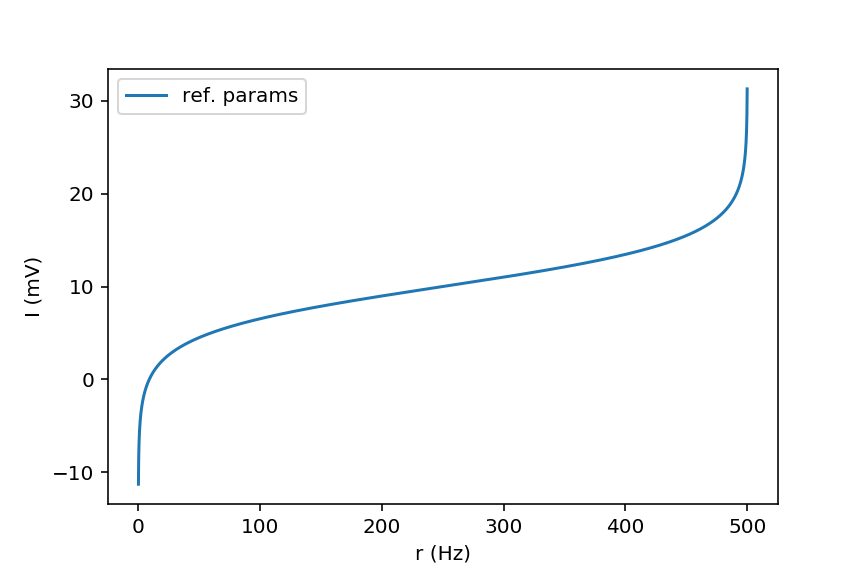

/Users/jranft/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in arctanh


In [51]:
# Plottez l'inverse de la courbe f-I
# --> est-ce qu'elle est définie pour 
# toutes les valeurs de r ?

r = np.arange(0,500,0.1)

fig, ax = plt.subplots()
ax.plot(r, fI_inv(r), label='ref. params')
ax.set_ylabel('I (mV)')
ax.set_xlabel('r (Hz)')
ax.legend()

<IPython.core.display.Javascript object>


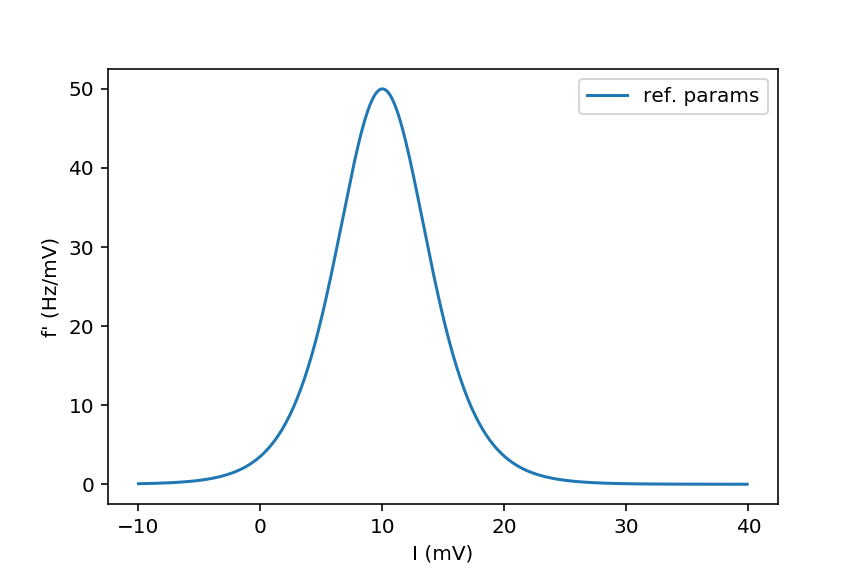

In [6]:
# Plottez la dérivée de la courve f-I


I = np.arange(-10,40,0.1)

fig, ax = plt.subplots()
ax.plot(I, fI_deriv(I), label='ref. params')
ax.set_xlabel('I (mV)')
ax.set_ylabel('f\' (Hz/mV)')
ax.legend()

## Dynamique avec courant externe constant

Pour un courant externe constant, on peut se demander si le réseau va atteindre un état stationnaire et si cet état sera stable. 

La première possibilité d'y répondre, c'est de resoudre numériquement l'équation différentielle et de déterminer ainsi la solution pour $r(t)$. 

### Inhibitory network

Plottez $r(t)$ pour différentes valeurs de $I_{ext}$ et de $w<0$, chaque fois pour des valeurs initiales $r(t=0)=0$ et $r(t=0)= r_{max}$. Qu'est-ce que vous observez ?   

In [52]:
# définissez la dérivée dr/dt(r,t) (la fonction 'f'
# des TD précédents) 

tau = 1 # setting tau = 1 is equivalent to 
        # measuring times in units of tau 

w = -1     # mV/Hz 
Iext = 3   # mV

def drdt(r, t=None, w=w, Iext=Iext):
    """Returns the derivative of the population firing rate
    r as a function of r, time, and the parameters w and Iext."""
    return (fI(Iext+w*r)-r)/tau

<IPython.core.display.Javascript object>


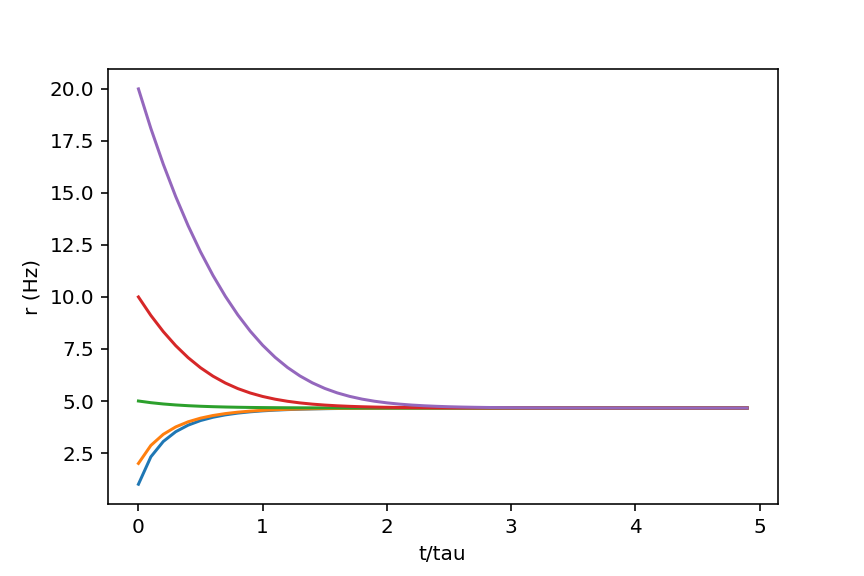

Text(0, 0.5, 'r (Hz)')

In [53]:
# Intégration numérique
# --> odeint ou la méthode d'Euler

# we can use the ODE solver routine from scipy
# (you can obtain equivalent results by numerical
# integration with the Euler method)
from scipy.integrate import odeint

# define the times for which we want to compute 
# the solution of r(t) for a given set of parameters
t = np.arange(0,5,0.1)

# compute the solution for different initial values
r0s= [1,2,5,10,20] # condition initiale

r_ts = []
for r0 in r0s:
    r_ts.append(odeint(drdt, r0, t))

fig, ax = plt.subplots()
for r_t in r_ts:
    ax.plot(t, r_t)
ax.set_xlabel('t/tau')
ax.set_ylabel('r (Hz)')


**Observation :** Pour toutes les valeurs initiales testées, le réseau finit par atteindre le même *état stationnaire* avec un taux de décharge constant. C'est un *point fixe* de la dynamique.

Est-ce qu'il y a la possibilité de déterminer l'état stationnaire ($r(t)=r^*=const.$) en partant de l'équation ? Plottez $dr/dt$ en fonction de $r$ pour les valeurs de $I_{ext}$ et $w$ choisies. Qu'est-ce que vous observez ?

<IPython.core.display.Javascript object>


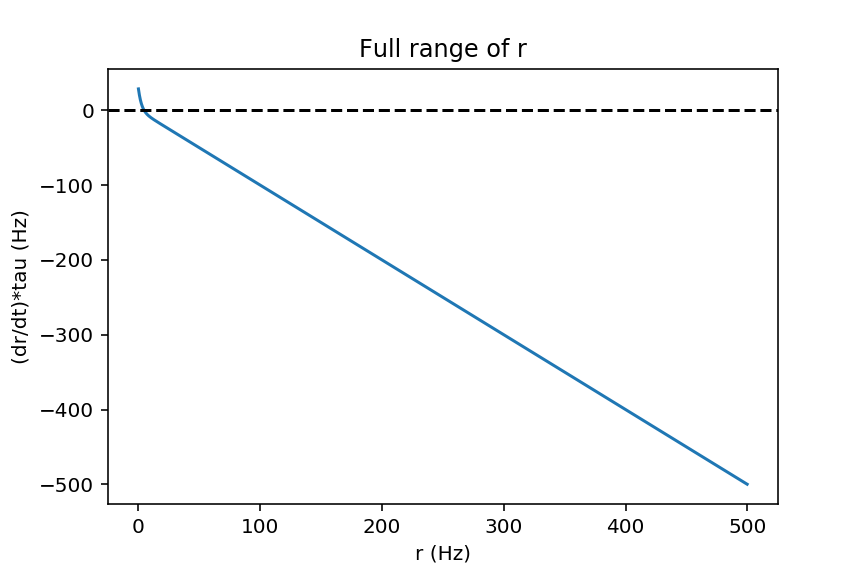

<IPython.core.display.Javascript object>


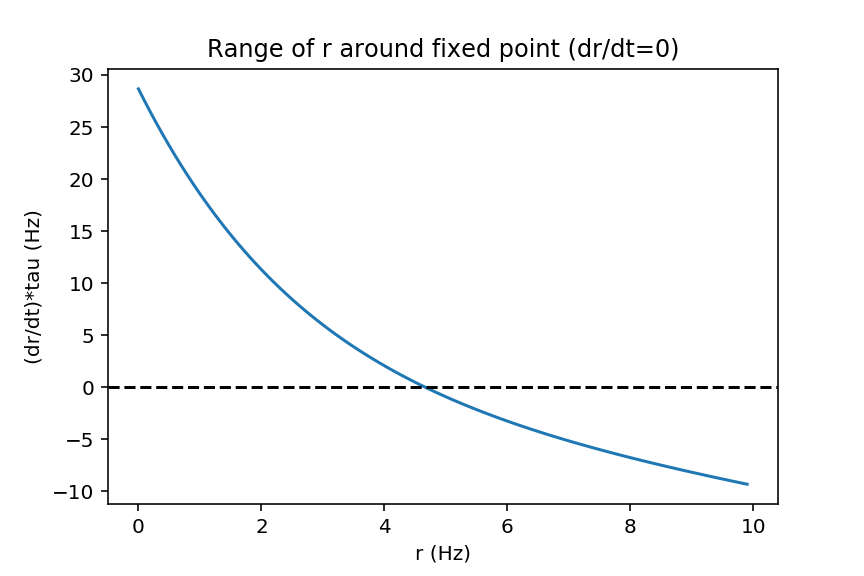

Text(0, 0.5, '(dr/dt)*tau (Hz)')

In [54]:
# Plotter drdt en fonction de r

r = np.arange(0,500,0.1)

fig, ax = plt.subplots()
ax.set_title('Full range of r')
ax.plot(r, drdt(r))
ax.axhline(0, ls='--', c='k')
ax.set_xlabel('r (Hz)')
ax.set_ylabel('(dr/dt)*tau (Hz)')


r = np.arange(0,10,0.1)

fig, ax = plt.subplots()
ax.set_title('Range of r around fixed point (dr/dt=0)')
ax.plot(r, drdt(r))
ax.axhline(0, ls='--', c='k')
ax.set_xlabel('r (Hz)')
ax.set_ylabel('(dr/dt)*tau (Hz)')

**Observation :** Il y a une seule valeur de $r=r^*$ pour laquelle la dérivé $dr/dt=0$ : cela veut dire que pour cette valeur, le taux de décharge reste constant,  c'est un (le seul) point fixe ! Et c'est justement le taux de décharge final observé quand nous laissons évolué le taux de décharge $r(t)$ dans le temps. 

Pour des valeurs plus petites ($r<r^*$), la dérivé $dr/dt>0$ et le taux de décharge $r(t)$ va augmenter et donc s'approcher du point fixe par le bas ; pour des valeurs plus grandes ($r>r^*$), la dérivé $dr/dt<0$ et le taux de décharge $r(t)$ va diminuer et s'approcher du point fixe par le haut.

Nous pouvons par la suite étudier comment le point fixe va changer en fonction des paramètres $I_{\rm ext}$ et $w$, c'est-à-dire le courant externe qui arrive à la population et le poids des connections synaptiques récurrentes. 

<IPython.core.display.Javascript object>


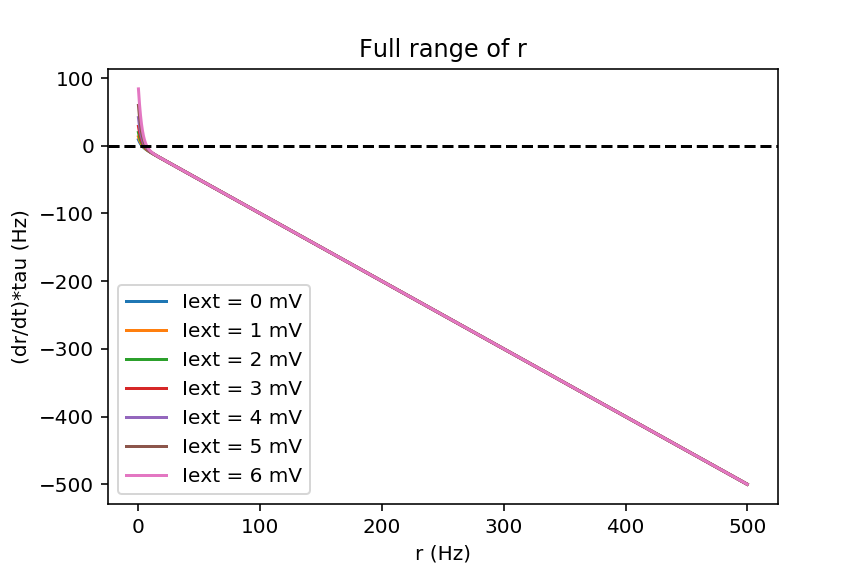

<IPython.core.display.Javascript object>


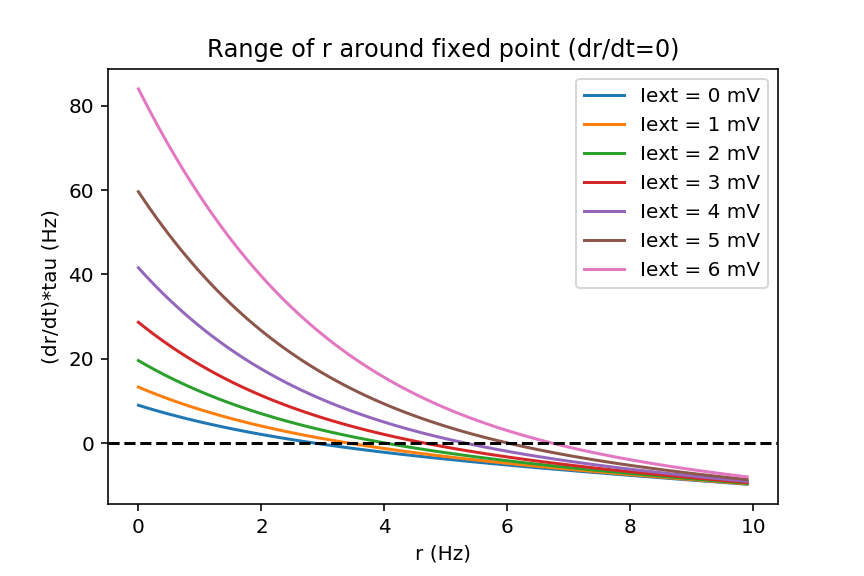

In [55]:
# Variation pour différentes valeurs de Iext

Iexts = np.arange(7) # mV

r = np.arange(0,500,0.1)

fig, ax = plt.subplots()
ax.set_title('Full range of r')
for Ie in Iexts:
    ax.plot(r, drdt(r,Iext=Ie), label='Iext = %g mV'%Ie)
ax.axhline(0, ls='--', c='k')
ax.set_xlabel('r (Hz)')
ax.set_ylabel('(dr/dt)*tau (Hz)')
ax.legend()

r = np.arange(0,10,0.1)

fig, ax = plt.subplots()
ax.set_title('Range of r around fixed point (dr/dt=0)')
for Ie in Iexts:
    ax.plot(r, drdt(r,Iext=Ie), label='Iext = %g mV'%Ie)
ax.axhline(0, ls='--', c='k')
ax.set_xlabel('r (Hz)')
ax.set_ylabel('(dr/dt)*tau (Hz)')
ax.legend()

**Observation :** Pour des valeurs grandissantes de $I_{\rm ext}$, le taux de décharge à l'état stationnaire augmente. (Pour $I_{\rm ext}=0$ mV (courbe bleu) on trouve $r^*\approx3$ Hz, pour $I_{\rm ext}=6$ mV (courbe rose) on trouve $r^*\approx7$ Hz.)

<IPython.core.display.Javascript object>


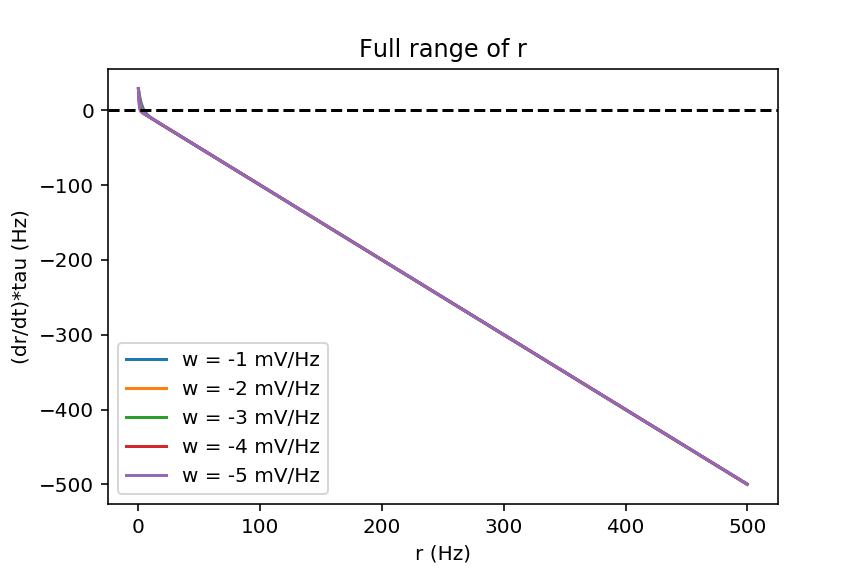

<IPython.core.display.Javascript object>


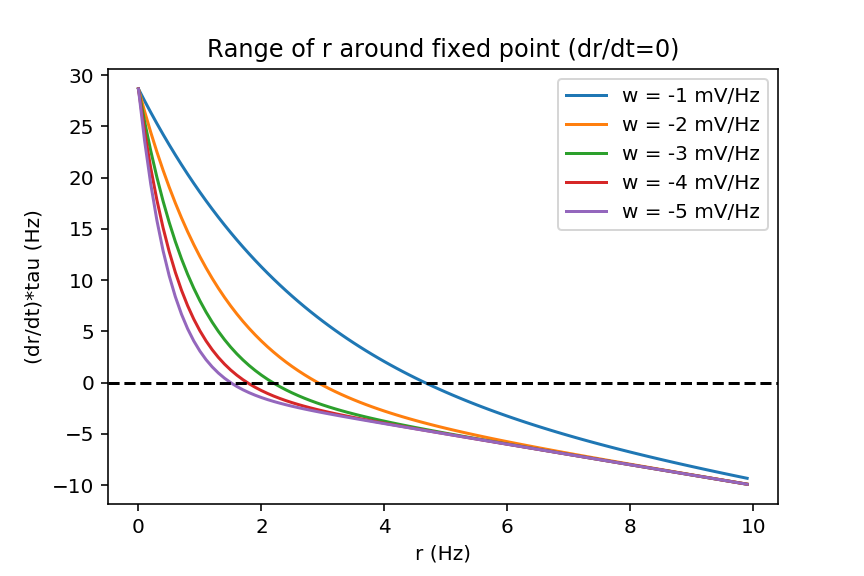

In [56]:
# Variation pour différentes valeurs de w

ws = np.arange(-1,-6,-1)

r = np.arange(0,500,0.1)

fig, ax = plt.subplots()
ax.set_title('Full range of r')
for w in ws:
    ax.plot(r, drdt(r,w=w), label='w = %g mV/Hz'%w)
ax.axhline(0, ls='--', c='k')
ax.set_xlabel('r (Hz)')
ax.set_ylabel('(dr/dt)*tau (Hz)')
ax.legend()

r = np.arange(0,10,0.1)

fig, ax = plt.subplots()
ax.set_title('Range of r around fixed point (dr/dt=0)')
for w in ws:
    ax.plot(r, drdt(r,w=w), label='w = %g mV/Hz'%w)
ax.axhline(0, ls='--', c='k')
ax.set_xlabel('r (Hz)')
ax.set_ylabel('(dr/dt)*tau (Hz)')
ax.legend()

**Observation :** Pour des valeurs plus importantes du poids de la connexion récurrrente inhibtrice $w$, le taux de décharge à l'état stationnaire diminue. Pour $w=-1$ mV/Hz (courbe bleu) on trouve $r^*\approx5$ Hz, pour $w=-5$ mV/Hz (courbe rose) on trouve $r^*\approx1.5$ Hz. 

En résumé, pour un réseau inhibiteur, il n'y a qu'un seul *point fixe* de la dynamique vers lequel le système converge dans le temps. La valeur finale du taux de décharge dépend des paramètres $I_{\rm ext}$ et $w$ de manière intuitive: plus il y a un courant stimulant externe, plus l'activité est élevée, plus il y a de l'inhibition récurrente, plus l'activité est basse. 

### Excitatory network

Plottez $r(t)$ pour différentes valeurs de $I_{ext}$, maintenant avec une valeur $w>0$, chaque fois pour des valeurs initiales $r(t=0)=0$ et $r(t=0)= r_{max}$. Qu'est-ce que vous observez ?

<IPython.core.display.Javascript object>


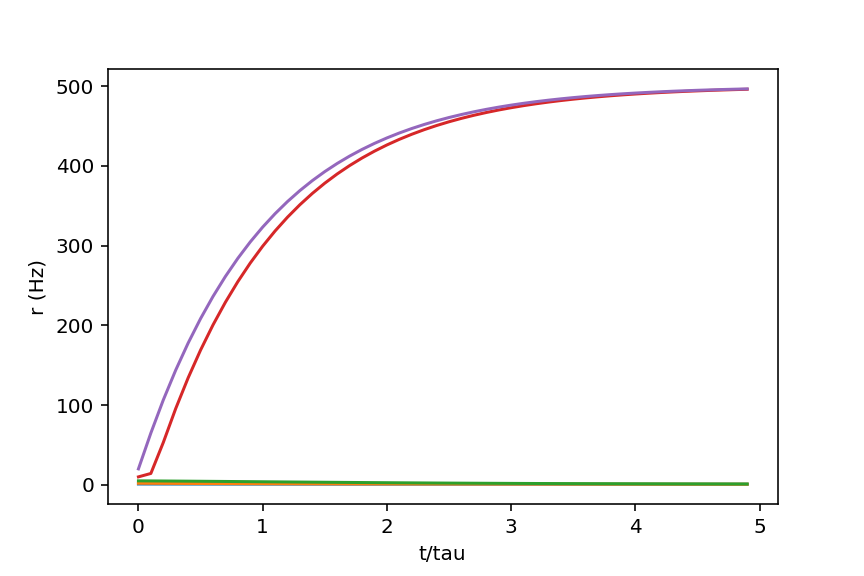

Text(0, 0.5, 'r (Hz)')

In [66]:
# choisir un w>0
w = 1 # mV/Hz

# choisir des Iext plus petit que pour w<0
Iext = -7 # mV

t = np.arange(0,5,0.1)

r0s= [1,2,5,10,20] # condition initiale

r_ts = []
for r0 in r0s:
    r_ts.append(odeint(drdt, r0, t, args=(w,Iext)))

fig, ax = plt.subplots()
for r_t in r_ts:
    ax.plot(t, r_t)
ax.set_xlabel('t/tau')
ax.set_ylabel('r (Hz)')


**Observation :** Il semble y avoir deux états stationnaires possibles pour des valeurs de $I_{\rm ext}$ suffisamment petites, la valeur finale de $r(t)$ dépendant de la valeur initiale $r(0)$.

Si vous plottez maintenant $dr/dt$ en fonction de $r$, qu'est-ce que vous observez ? A combien d'états stationnaires vous attendez-vous ?

<IPython.core.display.Javascript object>


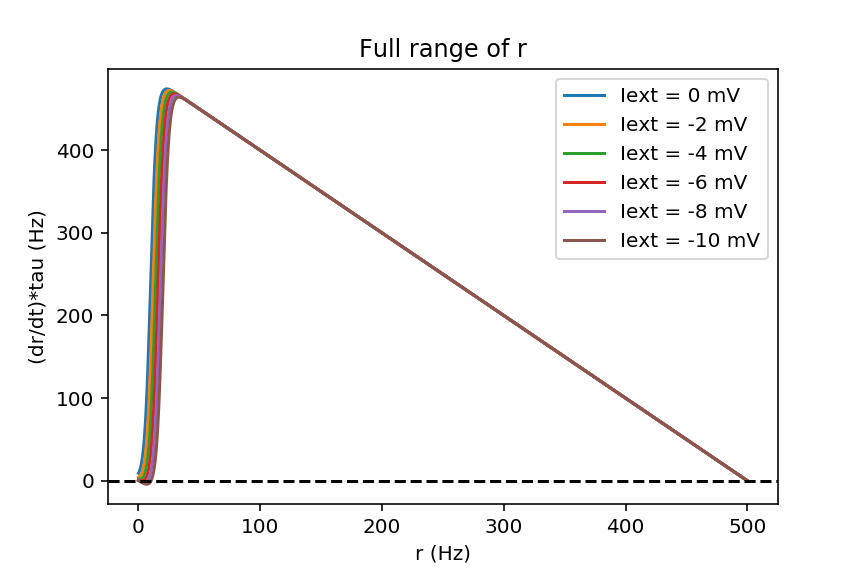

<IPython.core.display.Javascript object>


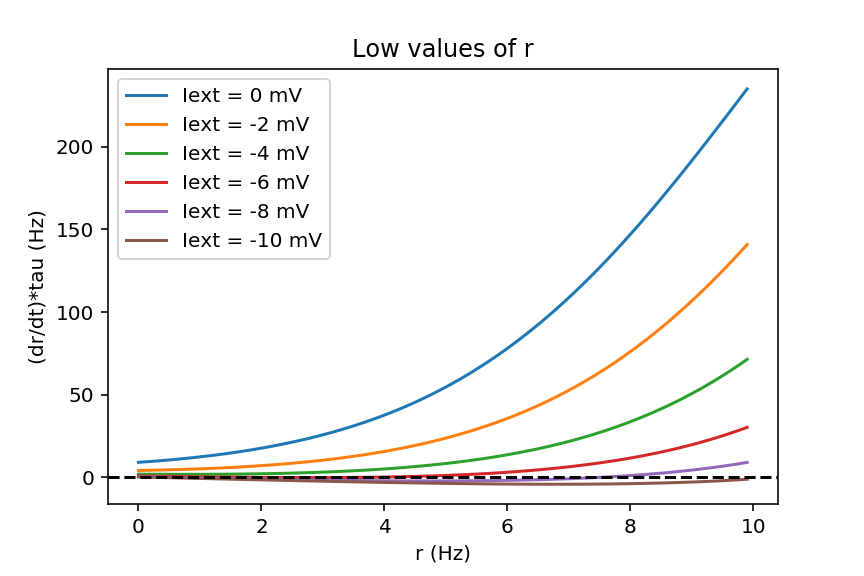

In [67]:
# Variation pour différentes valeurs de Iext

Iexts = np.arange(0,-11,-2) # mV

r = np.arange(0,500,0.1)

fig, ax = plt.subplots()
ax.set_title('Full range of r')
for Ie in Iexts:
    ax.plot(r, drdt(r,w=w,Iext=Ie), label='Iext = %g mV'%Ie)
ax.axhline(0, ls='--', c='k')
ax.set_xlabel('r (Hz)')
ax.set_ylabel('(dr/dt)*tau (Hz)')
ax.legend()

r = np.arange(0,10,0.1)

fig, ax = plt.subplots()
ax.set_title('Low values of r')
for Ie in Iexts:
    ax.plot(r, drdt(r,w=w,Iext=Ie), label='Iext = %g mV'%Ie)
ax.axhline(0, ls='--', c='k')
ax.set_xlabel('r (Hz)')
ax.set_ylabel('(dr/dt)*tau (Hz)')
ax.legend()

Nous pouvons observér que pour $I_{\rm ext}$ suffisamment petit, il y a *trois* points fixes, c'est-à-dire valeurs de $r$ pour lesquelles $dr/dt=0$. En plus du point fixe à très fort décharge ($r^*\approx500$ Hz), deux autres points fixes apparaissent à des taux de décharges plus faibles. Ils apparaissent comme un pair puisque $dr/dr$ devient d'abord négatif quand $r$ augmente, puis devient à nouveau positif pour $r$ encore plus grand. 


<IPython.core.display.Javascript object>


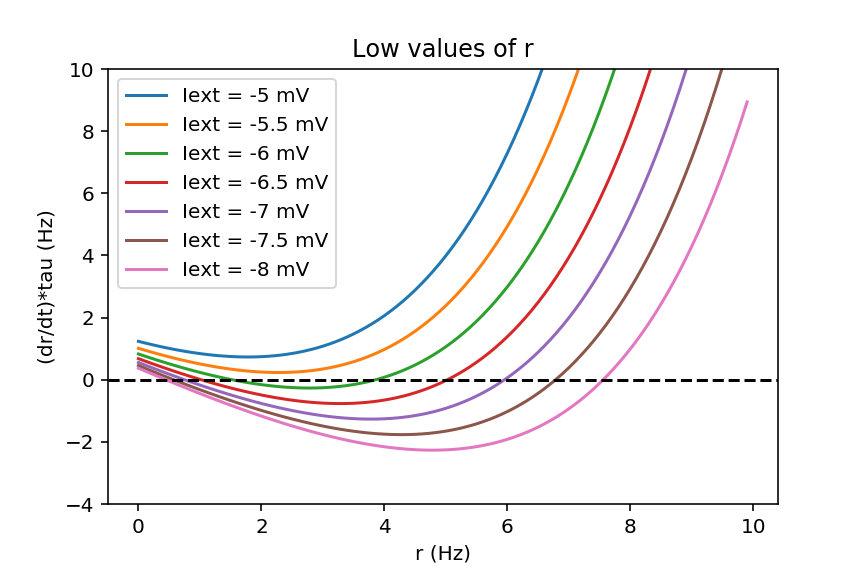

In [68]:
# on peut regarder de plus près autour du courant pour 
# lequel les deux points fixes supplémentaires apparaissent

w = 1 # mV/Hz
Iexts = np.arange(-5,-8.5,-0.5) # mV


r = np.arange(0,10,0.1)

fig, ax = plt.subplots()
ax.set_title('Low values of r')
for Ie in Iexts:
    ax.plot(r, drdt(r,w=w,Iext=Ie), label='Iext = %g mV'%Ie)
ax.axhline(0, ls='--', c='k')
ax.set_xlabel('r (Hz)')
ax.set_ylabel('(dr/dt)*tau (Hz)')
ax.set_ylim(-4,10)
ax.legend()

Dans le cas où il y a trois points fixes $r_1<r_2<r_3$, le point fixe au milieu sépare deux *bassins d'attraction* : Quand $r_1<r(t)<r_2$, $dr/dt<0$ et $r(t)$ va s'approcher du point fixe stable $r_1$. Quand $r_2<r(t)<r_3$, $dr/dt>0$ et $r(t)$ va s'approcher du point fixe stable $r_3$. Cela explique pourquoi nous avons observé qu'en fonction de l'état initial $r(0)$, le taux de décharge est arrivé dans deux états finaux différents.

Maintenant pour une valeur de $I_{ext}$ choisie, plottez $dr/dt$ et variez le poids de la connexion récurrente $w$. Est-ce que vous pouvez observez un changement *qualitatif* ?

<IPython.core.display.Javascript object>


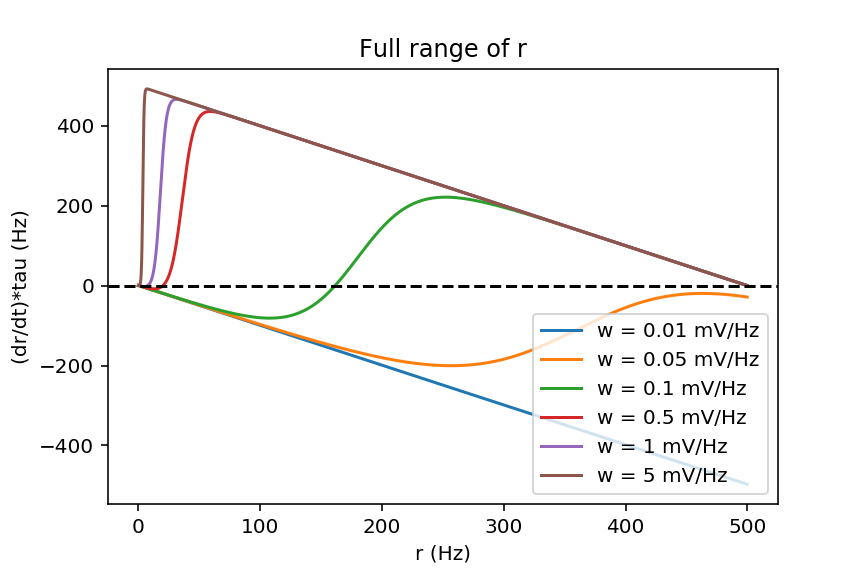

<IPython.core.display.Javascript object>


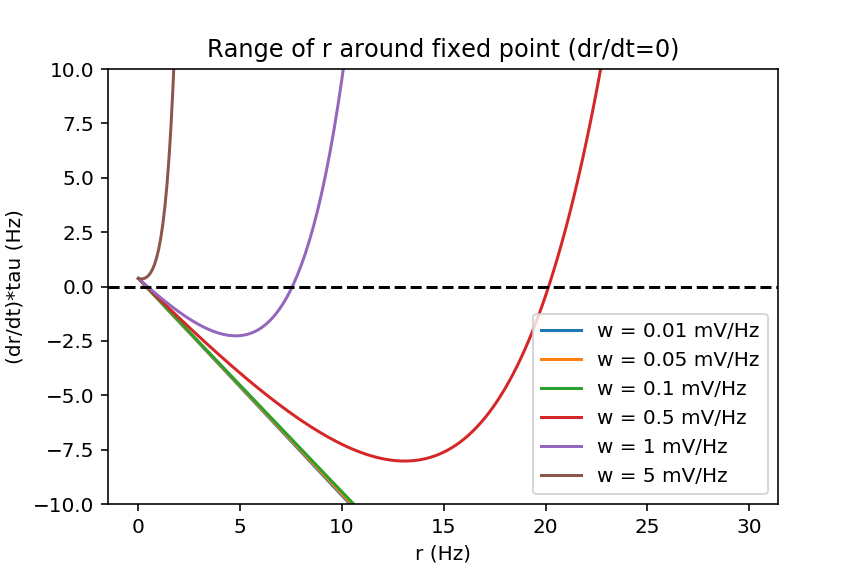

(-10, 10)

In [69]:
# Variation pour différentes valeurs de w

Iext = -8 # mV
ws = np.array([0.01, 0.05, 0.1,0.5, 1, 5 ]) # mV/Hz

r = np.arange(0,500,0.1)

fig, ax = plt.subplots()
ax.set_title('Full range of r')
for w in ws:
    ax.plot(r, drdt(r,w=w,Iext=Iext), label='w = %g mV/Hz'%w)
ax.axhline(0, ls='--', c='k')
ax.set_xlabel('r (Hz)')
ax.set_ylabel('(dr/dt)*tau (Hz)')
ax.legend()

r = np.arange(0,30,0.1)

fig, ax = plt.subplots()
ax.set_title('Range of r around fixed point (dr/dt=0)')
for w in ws:
    ax.plot(r, drdt(r,w=w,Iext=Iext), label='w = %g mV/Hz'%w)
ax.axhline(0, ls='--', c='k')
ax.set_xlabel('r (Hz)')
ax.set_ylabel('(dr/dt)*tau (Hz)')
ax.legend()
ax.set_ylim(-10,10)

**Observation :** Lors d'une variation de $w$, nous pouvons observer que deux régimes extrèmes existent dans lequel il n'y a qu'un seul point fixe - soit à taux de décharge faible si $w$ est suffisament petit, soit à taux de décharge très élevé si $w$ est assez grand. Entre ces deux extrèmes, il y a les trois points fixes discutés plus haut, avec un point fixe instable entre les deux points fixes à basse et forte activité. 

Est-ce que la stabilité peut être prédite par l'équation ? Considerez la dynamique d'une petite variation $\delta r$ autour du point fixe $r^*$, de sorte que $r(t) = r^* + \delta r(t)$. 

**Astuce :** Nous pouvons approximer une fonction $h(x)$ autour d'un point $x_0$ par sa dérivée selon de développement (jusqu'au premier ordre) :
$$h(x)\approx h(x_0) + h'(x_0)(x-x_0).$$ 

In [ ]:
# calcul sur papier, puis évaluation numérique...

**Calcul sur tableau lors du cours :**
    
$
\begin{aligned}
\tau \frac{d\delta r}{dt} &= \Phi(I_{ext} + w(r^* + \delta r)) - r^* - \delta r \\
&= \Phi(I_{ext}+w r^*) - r^* + \Phi'(I_{ext}+w r^*) w \delta r - \delta r \\
&= (\Phi'(I_{ext}+w r^*) w -1 ) \delta r 
\end{aligned}$

On constate qu'une petite perturbation va croitre/diminuer comme $\delta r(t) = \delta r(0) e^{\lambda t}$, avec le taux caractéristique $\lambda = \frac{\Phi'(I_{ext}+w r^*) w -1 }{\tau}$. Si $\lambda>0$, le point fixe $r^*$ est instable car chaque petite perturbation va croitre (le taux de décharge dévier d'avantage du point fixe) ; si $\lambda<0$, le point fixe est stable et $r(t)\to r^*$ avec $\delta r(t)\to 0$ pour une perturbation initiale $\delta r(0)$ suffisamment petite.
    

### Extra : détermination numérique d'un point fixe

Il n'est pas possible de calculer analytiquement le(s) point(s) fixe(s) $r^*$ pour qui $\frac{dr}{dt}=0$, ou

$$0 = \Phi(I_{ext}+wr^*) - r^*.$$

Par contre, nous pouvons trouver cette solution *numériquement*, par ex. en utilisant la fonction `brentq` du module `scipy.optimize`. Elle permet de déterminer le zéro d'une fonction $f$ si le zéro est situé entre deux valeurs $a,b$ pour lesquelles $f(a)\cdot f(b) <0 $ (c'est-à-dire pour l'une des valeurs la fonction est négative et pour l'autre positive). 

Une fois le point fixe trouvé, nous pouvons utiliser l'analyse ci-dessus pour vérifier sa stabilité !

In [70]:
from scipy.optimize import brentq
brentq?

In [74]:
# Restons sur le dernier exemple étudié :
# --> nous connaissons approximativement 
# la position de deux points fixes 
Iext = -8
w = 1

# point fixe stable :
rstar1 = brentq(drdt, 0, 5, args=(None,w,Iext))
print('Numerically determined fixed point: %.2f Hz'%rstar1)

# vérification de stabilité :
lam1 = (w*fI_deriv(Iext+w*rstar1)-1)/tau
print('Characteristic rate: %.2f 1/ms'%lam1)
if lam1<0:
    print('--> this fixed point is stable!')
else:
    print('--> this fixed point is unstable!')
print()

# point fixe instable :
rstar2 = brentq(drdt, 5, 15, args=(None,w,Iext))
print('Numerically determined fixed point: %.2f Hz'%rstar2)

# vérification de stabilité :
lam2 = (w*fI_deriv(Iext+w*rstar2)-1)/tau
print('Characteristic rate: %.2f 1/ms'%lam2)
if lam2<0:
    print('--> this fixed point is stable!')
else:
    print('--> this fixed point is unstable!')
print()

Numerically determined fixed point: 0.45 Hz
Characteristic rate: -0.82 1/ms
--> this fixed point is stable!

Numerically determined fixed point: 7.56 Hz
Characteristic rate: 1.98 1/ms
--> this fixed point is unstable!

